In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf

####################################################################################################
### Select SSIC Hierarchical Level

# 1. 'Section'
# 2. 'Division'
# 3. 'Group'
# 4. 'Class'
# 5. 'Subclass'

level = 'Division' 
topn = 3
####################################################################################################

# create ssic denormalized fact table
ssic_detailed_def_filepath = r"dataSources/DoS/ssic2020-detailed-definitions.xlsx"
ssic_alpha_index_filepath = r"dataSources/DoS/ssic2020-alphabetical-index.xlsx"

df_detailed_def = pd.read_excel(ssic_detailed_def_filepath, skiprows=4)
df_alpha_index = pd.read_excel(ssic_alpha_index_filepath, dtype=str, skiprows=5)
df_alpha_index = df_alpha_index.drop(df_alpha_index.columns[2], axis=1).dropna().rename(columns={'SSIC 2020': 'SSIC 2020','SSIC 2020 Alphabetical Index Description': 'Detailed Definitions'})

df_concat = pd.concat([df_detailed_def, df_alpha_index])

####################################################################################################
### Select which fact table to train/transform
# - df_detailed_def
# - df_concat       (concat of df_detailed_def and df_alpha_index)

df_data_dict = df_detailed_def 
####################################################################################################

# prep ssic_n tables for joining/merging and reference
# Section, 1-alpha 
ssic_1_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 1)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code']) 
ssic_1_raw['Groups Classified Under this Code'] = ssic_1_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_1 = ssic_1_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_1['Groups Classified Under this Code'] = ssic_1['Groups Classified Under this Code'].str.replace('•', '')
ssic_1['Section, 2 digit code'] = ssic_1['Groups Classified Under this Code'].str[0:2]
ssic_1 = ssic_1.rename(columns={'SSIC 2020': 'Section','SSIC 2020 Title': 'Section Title'})

# Division, 2-digit
ssic_2_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 2)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_2_raw['Groups Classified Under this Code'] = ssic_2_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_2 = ssic_2_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_2['Groups Classified Under this Code'] = ssic_2['Groups Classified Under this Code'].str.replace('•', '')
ssic_2 = ssic_2.rename(columns={'SSIC 2020': 'Division','SSIC 2020 Title': 'Division Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Group, 3-digit 
ssic_3_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 3)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_3_raw['Groups Classified Under this Code'] = ssic_3_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_3 = ssic_3_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_3['Groups Classified Under this Code'] = ssic_3['Groups Classified Under this Code'].str.replace('•', '')
ssic_3 = ssic_3.rename(columns={'SSIC 2020': 'Group','SSIC 2020 Title': 'Group Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Class, 4-digit
ssic_4_raw = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 4)].reset_index(drop=True).drop(columns=['Detailed Definitions', 'Cross References', 'Examples of Activities Classified Under this Code'])
ssic_4_raw['Groups Classified Under this Code'] = ssic_4_raw['Groups Classified Under this Code'].str.split('\n•')
ssic_4 = ssic_4_raw.explode('Groups Classified Under this Code').reset_index(drop=True)
ssic_4['Groups Classified Under this Code'] = ssic_4['Groups Classified Under this Code'].str.replace('•', '')
ssic_4 = ssic_4.rename(columns={'SSIC 2020': 'Class','SSIC 2020 Title': 'Class Title'}).drop(columns=['Groups Classified Under this Code']).drop_duplicates()

# Sub-class, 5-digit
ssic_5 = df_data_dict[df_data_dict['SSIC 2020'].apply(lambda x: len(str(x)) == 5)].reset_index(drop=True).drop(columns=['Groups Classified Under this Code'])
ssic_5.replace('<Blank>', '', inplace=True)
ssic_5.replace('NaN', '', inplace=True)

# prep join columns
ssic_5['Section, 2 digit code'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Division'] = ssic_5['SSIC 2020'].astype(str).str[:2]
ssic_5['Group'] = ssic_5['SSIC 2020'].astype(str).str[:3]
ssic_5['Class'] = ssic_5['SSIC 2020'].astype(str).str[:4]

# join ssic_n Hierarhical Layer Tables (Section, Division, Group, Class, Sub-Class)
ssic_df = pd.merge(ssic_5, ssic_1[['Section', 'Section Title', 'Section, 2 digit code']], on='Section, 2 digit code', how='left')
ssic_df = pd.merge(ssic_df, ssic_2[['Division', 'Division Title']], on='Division', how='left')
ssic_df = pd.merge(ssic_df, ssic_3[['Group', 'Group Title']], on='Group', how='left')
ssic_df = pd.merge(ssic_df, ssic_4[['Class', 'Class Title']], on='Class', how='left')


# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

# prep ssic_n dictionary df_prep
df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

# load model directly from huggingface
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained(model)
model = TFAutoModelForSequenceClassification.from_pretrained(model)

# Define the function to predict scores and categories
def predict_text(text, tokenizer, model):
    # Ensure the input text is a string and check if it is blank
    if not isinstance(text, str) or not text.strip():
        return ""
    
    # Tokenize the input text
    predict_input = tokenizer.encode(
        text,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )
    
    # Get the model output
    output = model(predict_input)[0]
    output_array = output.numpy()[0] 
    
    # Get the probabilities
    probs = tf.nn.softmax(output_array)
    
    # Get the top 10 predicted classes and their confidence scores
    top_10_indices = tf.argsort(probs, direction='DESCENDING')[:topn].numpy()
    return tuple(int(idx) for idx in top_10_indices)

    # top_10_probs = tf.gather(probs, top_10_indices).numpy()
    # top_10_predictions = [(int(idx), float(prob)) for idx, prob in zip(top_10_indices, top_10_probs)]
    
    # return top_10_predictions

def apply_model_to_column(df, input_col, output_col):
   
    def map_values(value_list):
        # Prepare the merged DataFrame
        lvl_dict = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()
        lvl_ref = ssic_lvl[[lvl_train, lvl_train_title]].drop_duplicates()
        merged_df = lvl_dict.merge(lvl_ref, on=lvl_train, how='left')
        
        # Create a mapping dictionary from the reference table
        mapping_dict = dict(zip(merged_df['encoded_cat'], merged_df[lvl_train]))
        
        return [mapping_dict.get(item, item) for item in value_list]
    
    def predict_and_map(text):
        predictions = predict_text(text, tokenizer, model)
        return map_values(predictions)
    
    # Apply the predict_and_map function to the specified column and store results in a new column
    df[output_col] = df[input_col].apply(predict_and_map)
    return df


import pandas as pd
list_df_filepath = r"dataSources\ScrapedOutputFiles\List of 90 Coy and SSIC.csv"
list_df = pd.read_csv(list_df_filepath, dtype = str)

# Create new columns
list_df['Division'] = list_df['ssic_code'].str[:2]
list_df['Group'] = list_df['ssic_code'].str[:3]
list_df['Class'] = list_df['ssic_code'].str[:4]
list_df['Sub-class'] = list_df['ssic_code']

list_df['Division2'] = list_df['ssic_code2'].str[:2]
list_df['Group2'] = list_df['ssic_code2'].str[:3]
list_df['Class2'] = list_df['ssic_code2'].str[:4]
list_df['Sub-class2'] = list_df['ssic_code2']

list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division', right_on='Section, 2 digit code', how='left')
list_df = list_df.rename(columns={'Section': 'Section'})
list_df = list_df.merge(ssic_1[['Section, 2 digit code', 'Section']], left_on='Division2', right_on='Section, 2 digit code', how='left', suffixes=('', '2'))
list_df = list_df.rename(columns={'Section2': 'Section2'})

# Validation Data
# vdf_filepath = r"dataSources\ScrapedOutputFiles\(Roy) data validation.xlsx"
vdf = pd.read_excel("D:\ssicsync\LLM_Test\Summarised_output_for_model_v4.xlsx",  dtype = str)

vdf = vdf.merge(list_df[['UEN', 'ssic_code', 'ssic_code2', 'Section', 'Division', 'Group', 'Class', 'Sub-class', 'Section2', 'Division2', 'Group2', 'Class2', 'Sub-class2']], left_on='UEN Number', right_on='UEN', how='left')

# # Replace empty strings with NaN
# vdf = vdf.replace('', None)
# # Drop rows with any NaN values
# vdf = vdf.dropna()

# Create a dictionary for quick lookup for ssic_5

ssic_5_dict = ssic_5[['SSIC 2020', 'SSIC 2020 Title']].drop_duplicates().set_index('SSIC 2020')['SSIC 2020 Title'].to_dict()

# Function to create the combined title column
def get_combined_title(row):
    title1 = ssic_5_dict.get(row['ssic_code'], 'Unknown')
    title2 = ssic_5_dict.get(row['ssic_code2'], 'Unknown')
    return f"{row['ssic_code']}: {title1}\n{row['ssic_code2']}: {title2}"

# Apply the function to create the new column
vdf['ssic_code&title'] = vdf.apply(get_combined_title, axis=1)

pd.set_option('display.max_columns', None)  # None means no limit

# Summarized_Description_azma_bart / Azma_bart_tfidf
# Summarized_Description_facebook_bart / FB_bart_tfidf
# Summarized_Description_philschmid_bart / Philschmid_bart_tfidf

vdf = apply_model_to_column(vdf, 'Summarized_Description_azma_bart', 'p_sd_azma_bart')
vdf = apply_model_to_column(vdf, 'Summarized_Description_facebook_bart', 'p_sd_fb_bart')
vdf = apply_model_to_column(vdf, 'Summarized_Description_philschmid_bart', 'p_sd_philschmid_bart')
vdf = apply_model_to_column(vdf, 'Azma_bart_tfidf', 'p_azma_bart_tfidf')
vdf = apply_model_to_column(vdf, 'FB_bart_tfidf', 'p_fb_bart_tfidf')
vdf = apply_model_to_column(vdf, 'Philschmid_bart_tfidf', 'p_philschmid_bart_tfidf')
vdf = apply_model_to_column(vdf, 'Q&A model Output', 'p_QA')

vdf = apply_model_to_column(vdf, 'llama3_tfidf', 'p_llama_tfidf')
vdf = apply_model_to_column(vdf, 'llm_output_llama3.1', 'p_llama')
vdf = apply_model_to_column(vdf, 'llm_output_gemma', 'gemma')
vdf = apply_model_to_column(vdf, 'llm_output_mistral', 'mistral')
#gemma_tfidf
vdf=apply_model_to_column(vdf, 'gemma_tfidf', 'p_gemma_tfidf')
#	mistral_tfidf
vdf=apply_model_to_column(vdf, 'mistral_tfidf', 'p_mistral_tfidf')

########################################################################## Translate ssic code to title desc
translate_switch = 'On'

# Step 1: Create a dictionary from ssic_df
ssic_dict = dict(zip(ssic_df['SSIC 2020'], ssic_df['SSIC 2020 Title']))

# Step 2: Define a function to map the codes to their descriptions
def map_codes_to_desc(codes):
    return '\n'.join([f"{code}: {ssic_dict.get(code, 'Description not found')}" for code in codes])

# Step 3: Apply this function to the p_columns in vdf

list_columns = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA','p_llama','p_llama_tfidf','gemma','p_gemma_tfidf','mistral','p_mistral_tfidf']

# Switch to control the execution of the code section
if translate_switch == 'On':
    # Step 3: Apply the function to each column in the list
    for column in list_columns:
        vdf[column + '_desc'] = vdf[column].apply(map_codes_to_desc)

########################################################################## Define functions to check conditions
# Create a dictionary from the reference DataFrame for mapping
ref_dict = pd.Series(ssic_1['Section'].values, index=ssic_1['Section, 2 digit code']).to_dict()

def check_section(row, ref_dict, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
    # Check if the list is empty or null
    if not predictions:
        return None
    mapped_predictions = [ref_dict.get(str(pred)[:2]) for pred in row[prediction_col_name] if str(pred)[:2] in ref_dict]
    if row['Section'] in mapped_predictions or row['Section2'] in mapped_predictions:
        return 'Y'
    else:
        return 'N'

def check_division(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if the first 2 characters of any item in predictions match either Group or Group2
    return 'Y' if any(item[:2] == row['Division'] or item[:2] == row['Division2'] for item in row[prediction_col_name]) else 'N'

def check_group(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:3] == row['Group'] or item[:3] == row['Group2'] for item in row[prediction_col_name]) else 'N'

def check_class(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:4] == row['Class'] or item[:4] == row['Class2'] for item in row[prediction_col_name]) else 'N'

def check_subclass(row, prediction_col_name):
    # Retrieve the list of predictions from the specified column
    predictions = row[prediction_col_name]
        # Check if the list is empty or null
    if not predictions:
        return None
    # Check if any item in predictions matches either Division or Division2
    return 'Y' if any(item[:5] == row['Sub-class'] or item[:5] == row['Sub-class2'] for item in row[prediction_col_name]) else 'N'

#list_columns = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
list_columns = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart', 'p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA','p_llama','p_llama_tfidf','gemma','p_gemma_tfidf','mistral','p_mistral_tfidf']

# Apply the functions to create new columns
for p_column_to_check in list_columns:
    vdf[p_column_to_check + '_Section_check'] = vdf.apply(lambda row: check_section(row, ref_dict, p_column_to_check), axis=1)
    vdf[p_column_to_check + '_Division_check'] = vdf.apply(check_division, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Group_check'] = vdf.apply(check_group, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Class_check'] = vdf.apply(check_class, prediction_col_name=p_column_to_check, axis=1)
    vdf[p_column_to_check + '_Subclass_check'] = vdf.apply(check_subclass, prediction_col_name=p_column_to_check, axis=1)

check_columns = [col for col in vdf.columns if col.endswith('_check')]

# Calculate the counts, ratios, and info_column
vdf[['count_Y', 'count_N', 'total_Y_N', 'YN_ratio', 'info_column']] = vdf.apply(
    lambda row: pd.Series({
        'count_Y': (row[check_columns] == 'Y').sum(),
        'count_N': (row[check_columns] == 'N').sum(),
        'total_Y_N': (row[check_columns] == 'Y').sum() + (row[check_columns] == 'N').sum(),
        'Y_to_N_ratio': (row[check_columns] == 'Y').sum() / (row[check_columns] == 'N').sum() if (row[check_columns] == 'N').sum() != 0 else np.nan,
        'info_column': (
            lambda counts: f"Y: {counts['Y']}/{counts['total']} ({counts['Y'] / counts['total']:.2%}), "
                          f"N: {counts['N']}/{counts['total']} ({counts['N'] / counts['total']:.2%}), "
                          f"Y:N Ratio: {counts['Y'] / counts['N'] if counts['N'] != 0 else np.nan:.2f}"
        )({
            'Y': (row[check_columns] == 'Y').sum(),
            'N': (row[check_columns] == 'N').sum(),
            'total': (row[check_columns] == 'Y').sum() + (row[check_columns] == 'N').sum()
        })
    }),
    axis=1
)

#vdf.to_excel('vdf v2.xlsx', index=False)
vdf.head(2)

d:\Anaconda\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
d:\Anaconda\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\Admin\AppData\Local\Temp\ipykernel_27688\3888242455.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
Some layers from the model checkpoint at nusebacra/ssicsync_division_classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
-

,PDF Name,Page Number,UEN Number,Notes Page Content,llm_output_llama3.1,llm_output_gemma,llm_output_mistral,Sentence Count,llama3_tfidf,gemma_tfidf,mistral_tfidf,Summarized_Description_azma_bart,Summarized_Description_facebook_bart,Summarized_Description_philschmid_bart,Input_length,Summarised?,Azma_bart_tfidf,FB_bart_tfidf,Philschmid_bart_tfidf,Q&A model Output,UEN,ssic_code,ssic_code2,Section,Division,Group,Class,Sub-class,Section2,Division2,Group2,Class2,Sub-class2,ssic_code&title,p_sd_azma_bart,p_sd_fb_bart,p_sd_philschmid_bart,p_azma_bart_tfidf,p_fb_bart_tfidf,p_philschmid_bart_tfidf,p_QA,p_llama_tfidf,p_llama,gemma,mistral,p_gemma_tfidf,p_mistral_tfidf,p_sd_azma_bart_desc,p_sd_fb_bart_desc,p_sd_philschmid_bart_desc,p_azma_bart_tfidf_desc,p_fb_bart_tfidf_desc,p_philschmid_bart_tfidf_desc,p_QA_desc,p_llama_desc,p_llama_tfidf_desc,gemma_desc,p_gemma_tfidf_desc,mistral_desc,p_mistral_tfidf_desc,p_sd_azma_bart_Section_check,p_sd_azma_bart_Division_check,p_sd_azma_bart_Group_check,p_sd_azma_bart_Class_check,p_sd_azma_bart_Subclass_check,p_sd_fb_bart_Section_check,p_sd_fb_bart_Division_check,p_sd_fb_bart_Group_check,p_sd_fb_bart_Class_check,p_sd_fb_bart_Subclass_check,p_sd_philschmid_bart_Section_check,p_sd_philschmid_bart_Division_check,p_sd_philschmid_bart_Group_check,p_sd_philschmid_bart_Class_check,p_sd_philschmid_bart_Subclass_check,p_azma_bart_tfidf_Section_check,p_azma_bart_tfidf_Division_check,p_azma_bart_tfidf_Group_check,p_azma_bart_tfidf_Class_check,p_azma_bart_tfidf_Subclass_check,p_fb_bart_tfidf_Section_check,p_fb_bart_tfidf_Division_check,p_fb_bart_tfidf_Group_check,p_fb_bart_tfidf_Class_check,p_fb_bart_tfidf_Subclass_check,p_philschmid_bart_tfidf_Section_check,p_philschmid_bart_tfidf_Division_check,p_philschmid_bart_tfidf_Group_check,p_philschmid_bart_tfidf_Class_check,p_philschmid_bart_tfidf_Subclass_check,p_QA_Section_check,p_QA_Division_check,p_QA_Group_check,p_QA_Class_check,p_QA_Subclass_check,p_llama_Section_check,p_llama_Division_check,p_llama_Group_check,p_llama_Class_check,p_llama_Subclass_check,p_llama_tfidf_Section_check,p_llama_tfidf_Division_check,p_llama_tfidf_Group_check,p_llama_tfidf_Class_check,p_llama_tfidf_Subclass_check,gemma_Section_check,gemma_Division_check,gemma_Group_check,gemma_Class_check,gemma_Subclass_check,p_gemma_tfidf_Section_check,p_gemma_tfidf_Division_check,p_gemma_tfidf_Group_check,p_gemma_tfidf_Class_check,p_gemma_tfidf_Subclass_check,mistral_Section_check,mistral_Division_check,mistral_Group_check,mistral_Class_check,mistral_Subclass_check,p_mistral_tfidf_Section_check,p_mistral_tfidf_Division_check,p_mistral_tfidf_Group_check,p_mistral_tfidf_Class_check,p_mistral_tfidf_Subclass_check,count_Y,count_N,total_Y_N,YN_ratio,info_column
0,ABR HOLDINGS LIMITED 2022 (197803023H).pdf,74,197803023H,principal activities of the Company are the ma...,principal activities of the Company are the ma...,principal activities of the Company are the ma...,principal activities of the Company are the ma...,1,manufacture ice cream operation swensen ice cr...,manufacture ice cream operation swensen ice cr...,manufacture ice cream operation swensen ice cr...,principal activities of the Company are the ma...,principal activities of the Company are the ma...,principal activities of the Company are the ma...,29,No,manufacture ice cream operation swensen ice cr...,manufacture ice cream operation swensen ice cr...,manufacture ice cream operation swensen ice cr...,manufacture of ice cream,197803023H,47219,64202,G,47,472,4721,47219,K,64,642,6420,64202,47219: Retail sale of food n.e.c.\n64202: Othe...,"[10, 56, 64]","[10, 56, 64]","[10, 56, 64]","[56, 10, 11]","[56, 10, 93]","[56, 10, 93]","[10, 11, 56]","[56, 10, 11]","[10, 56, 64]","[10, 56, 64]","[10, 56, 64]","[56, 10, 11]","[56, 10, 11]",10: Description not found\n56: Description not...,10: Description not found\n56: Description not...,10: Description not found\n56: Description not...,56: Description not found\n10: Description not...,56: Description not

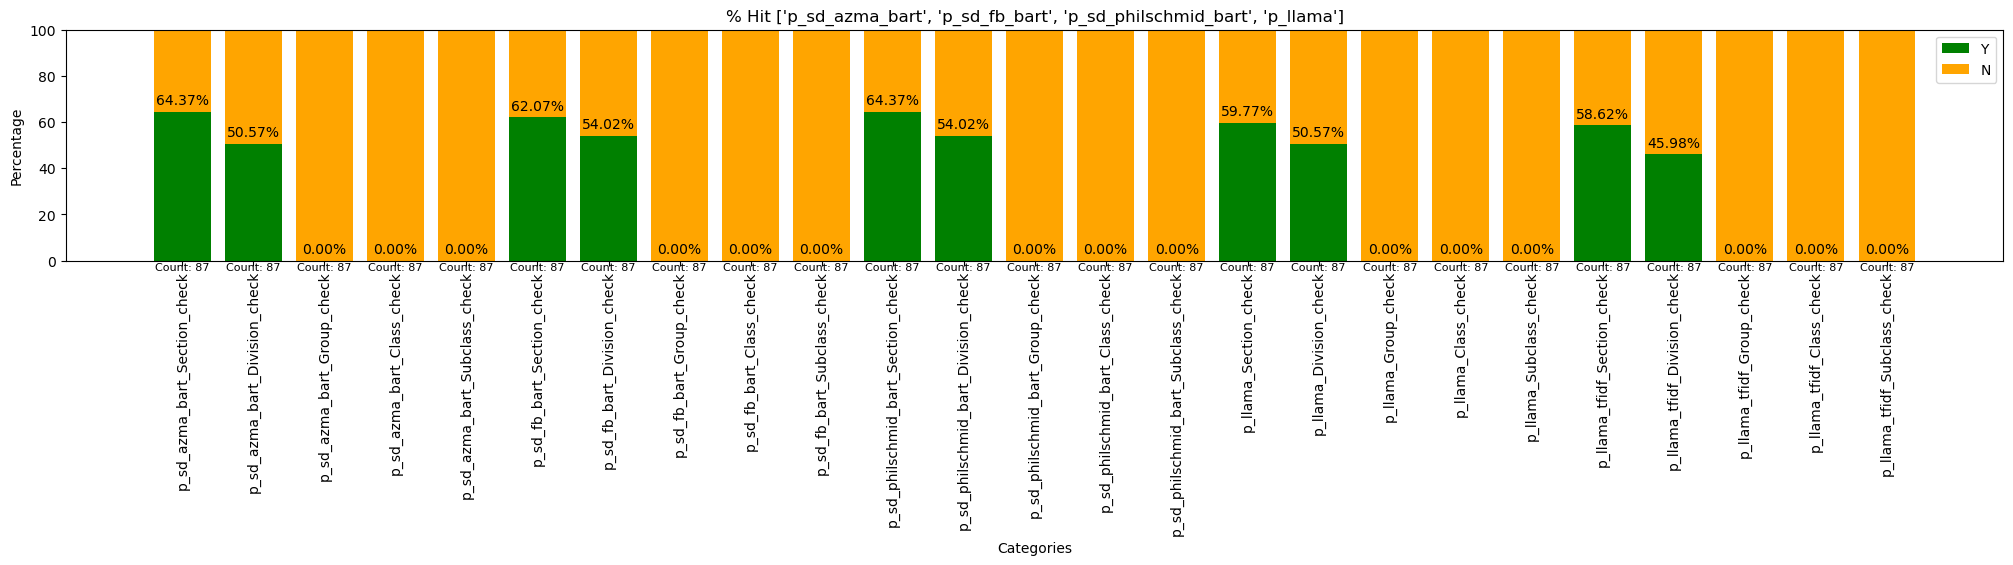

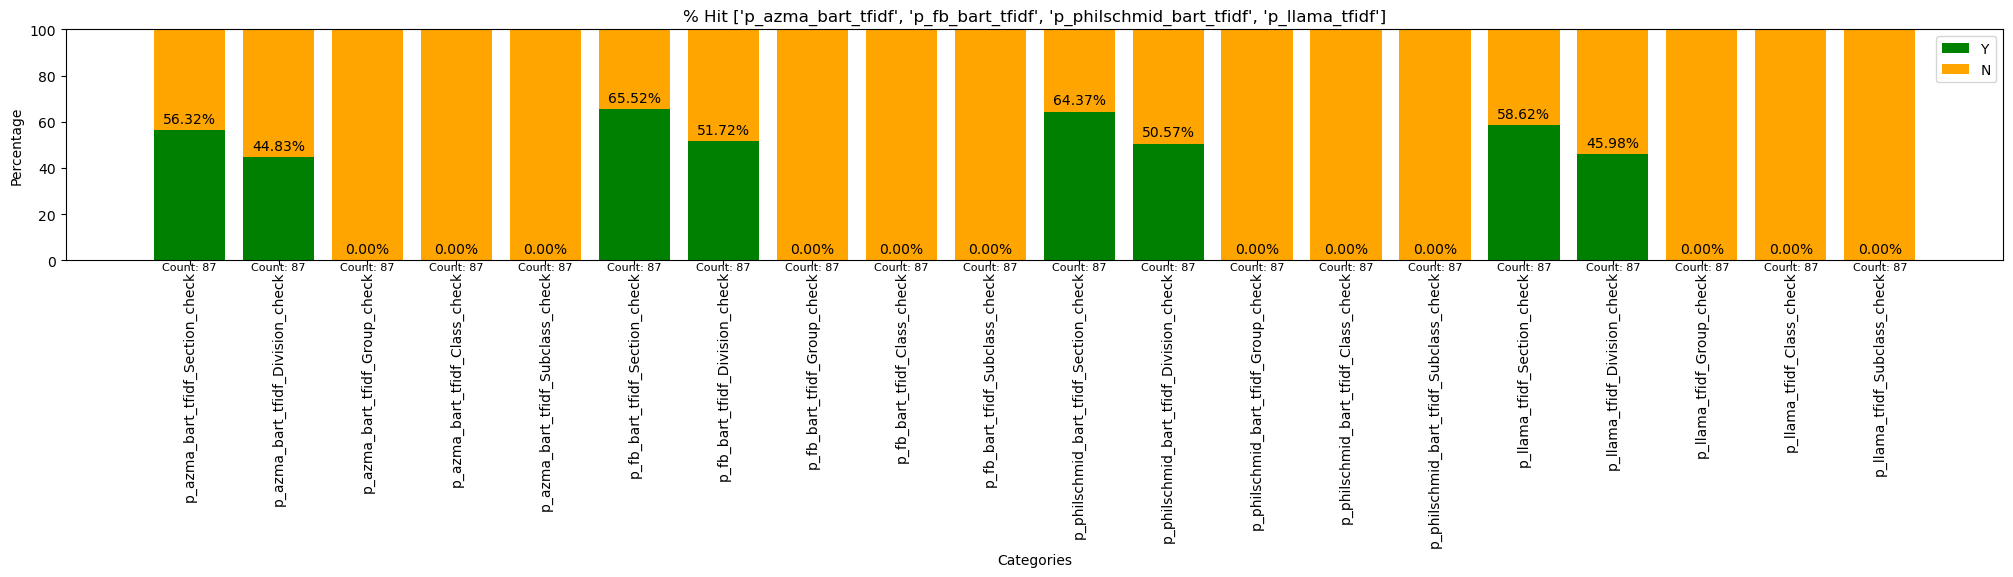

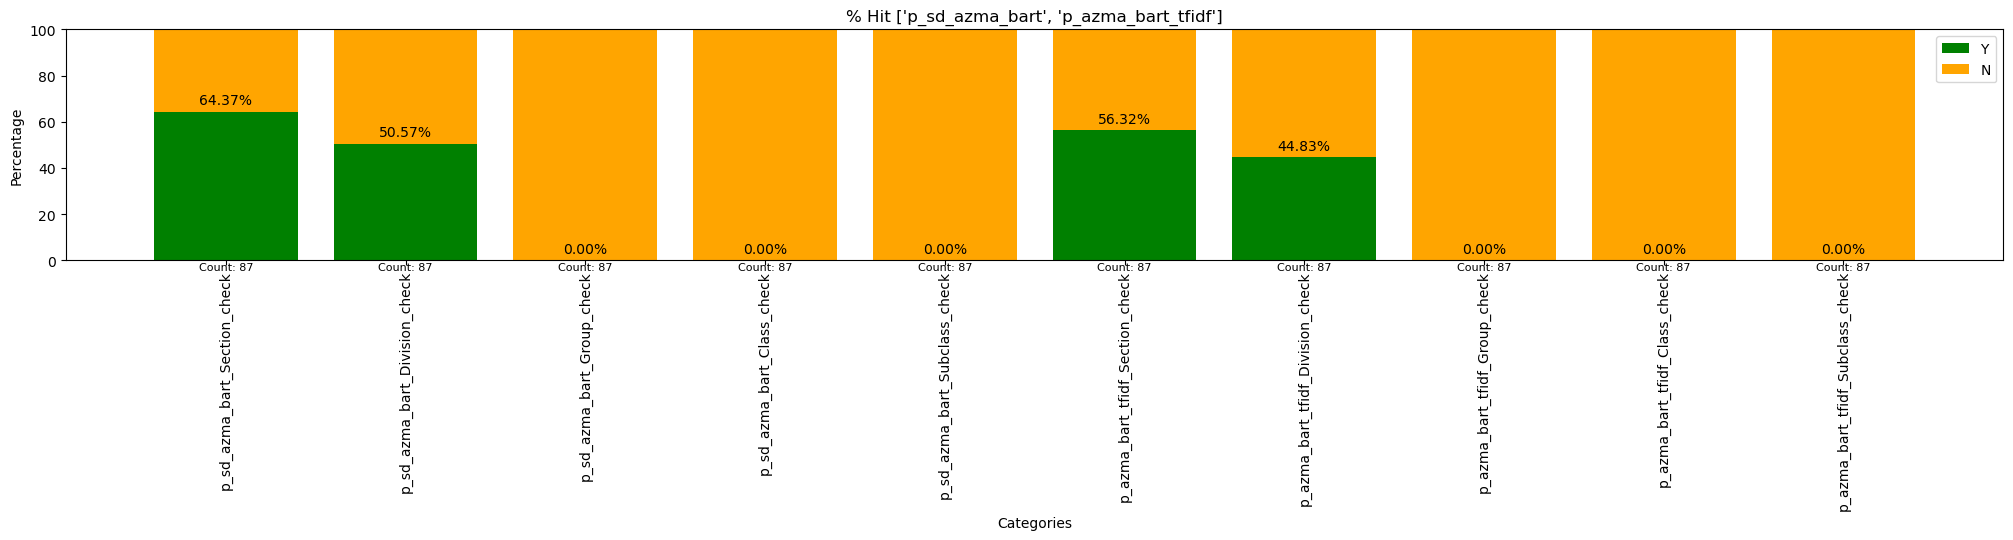

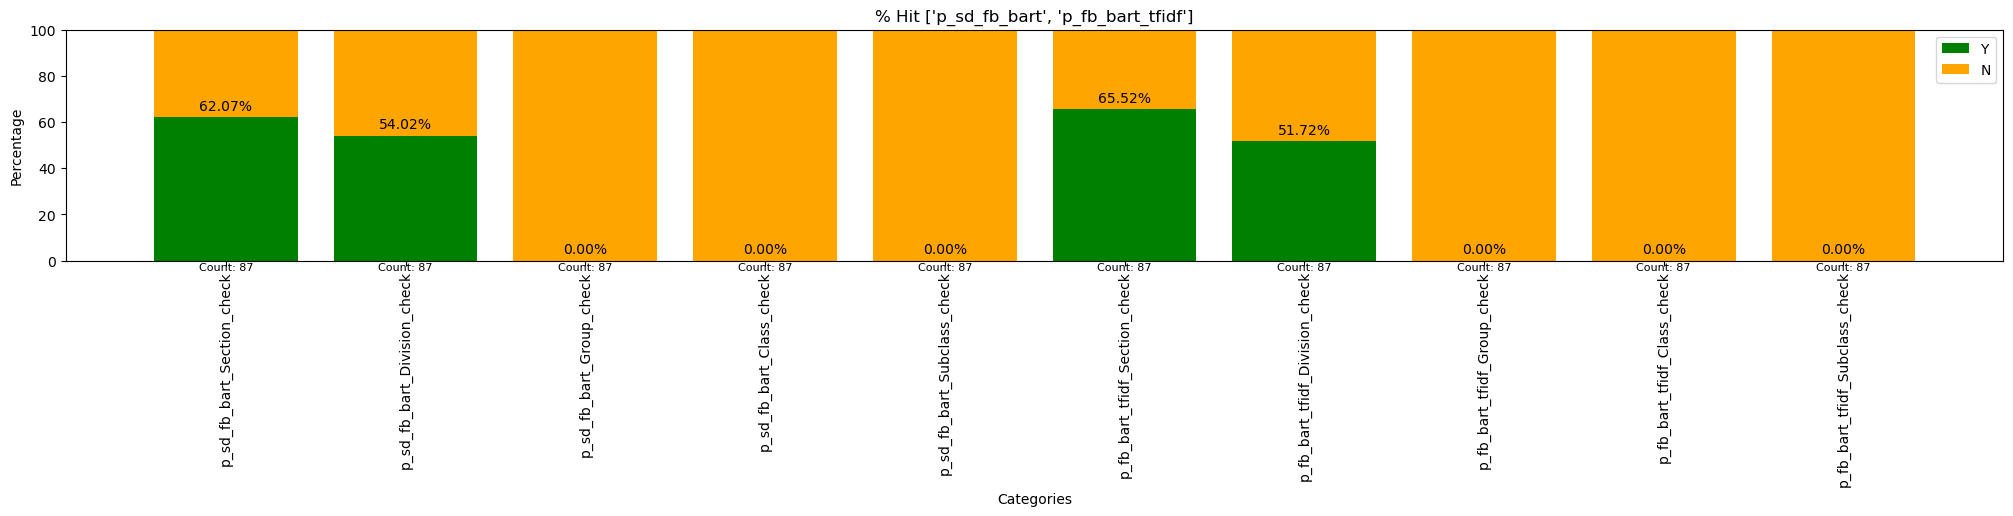

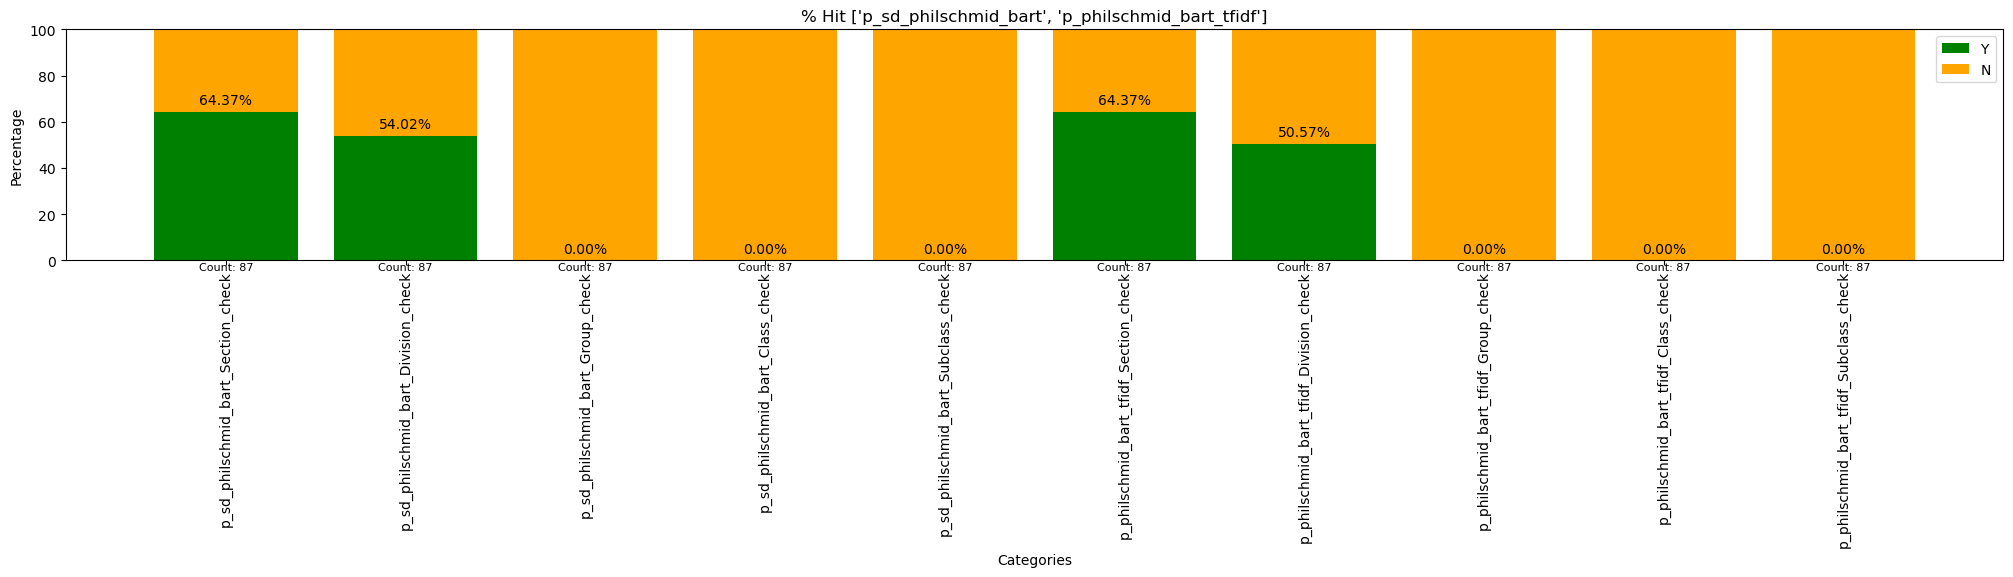

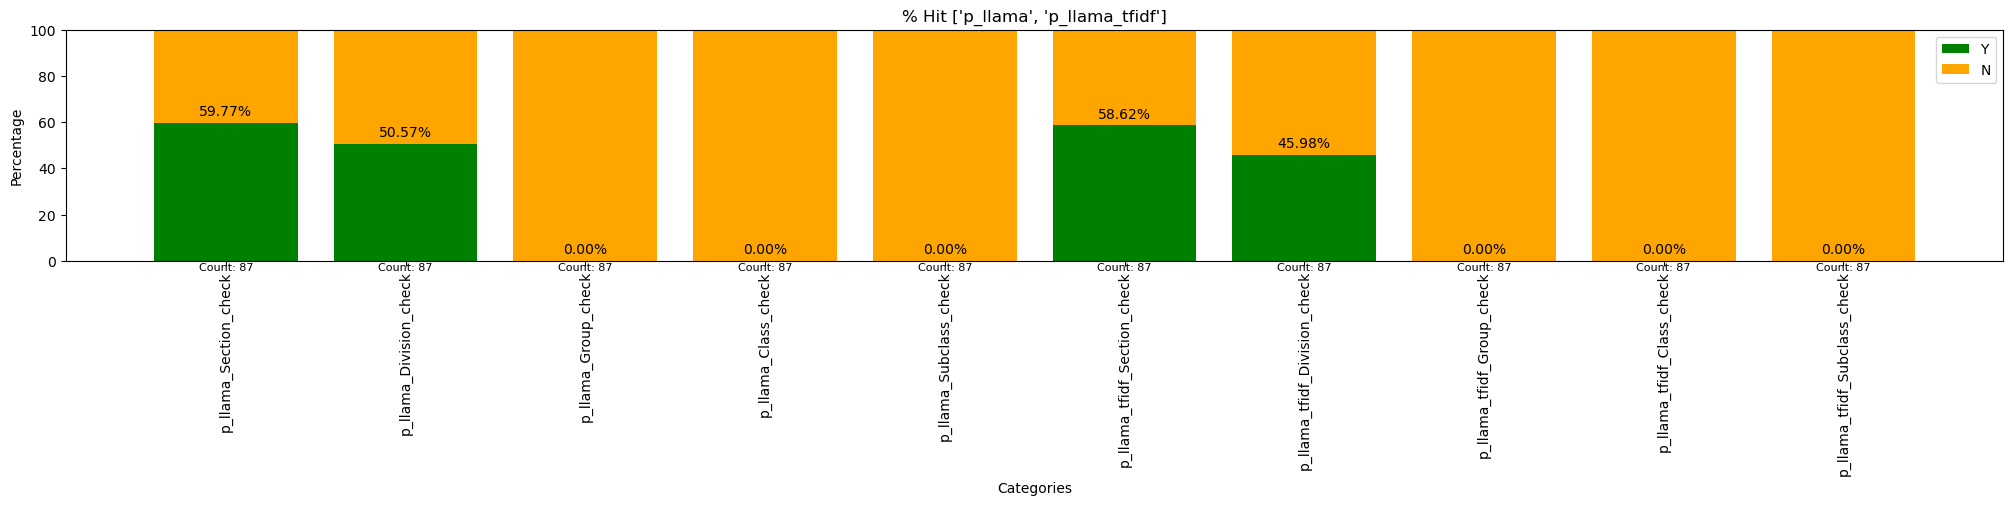

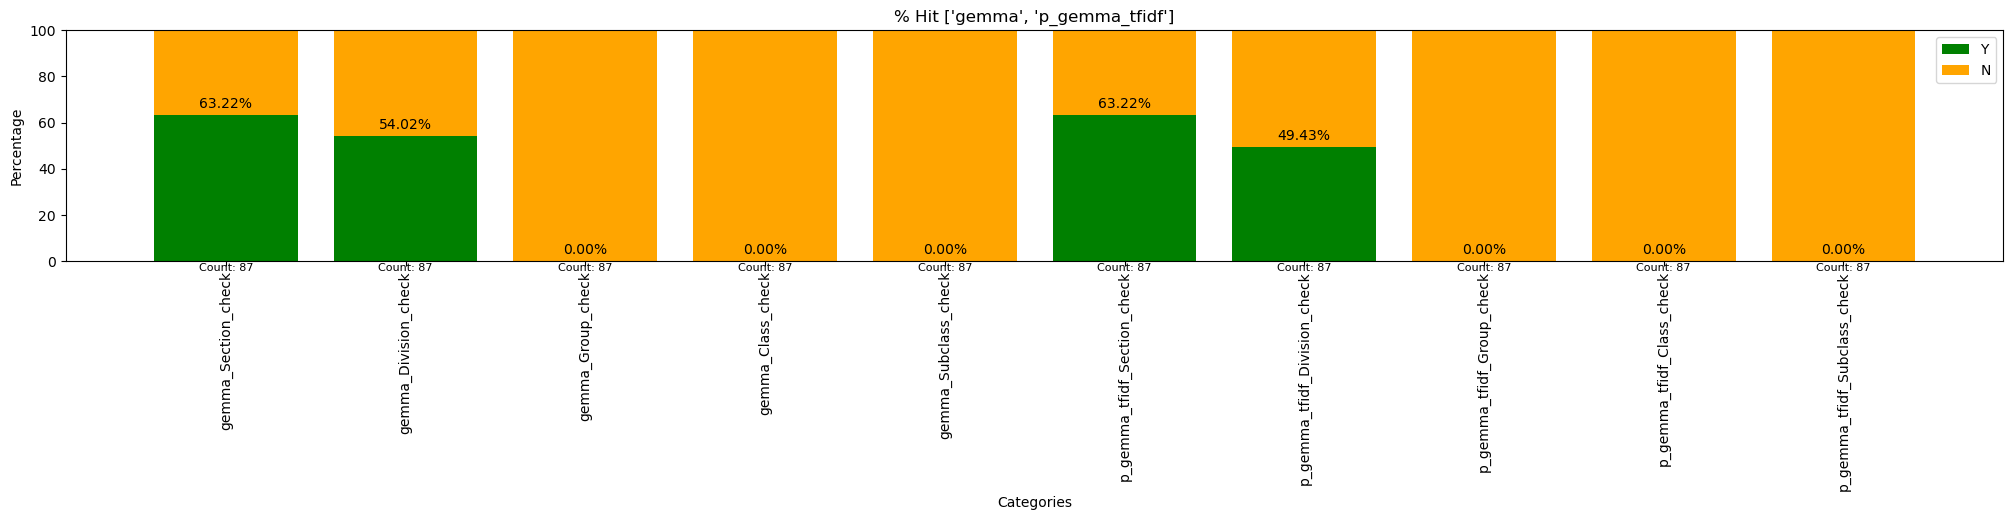

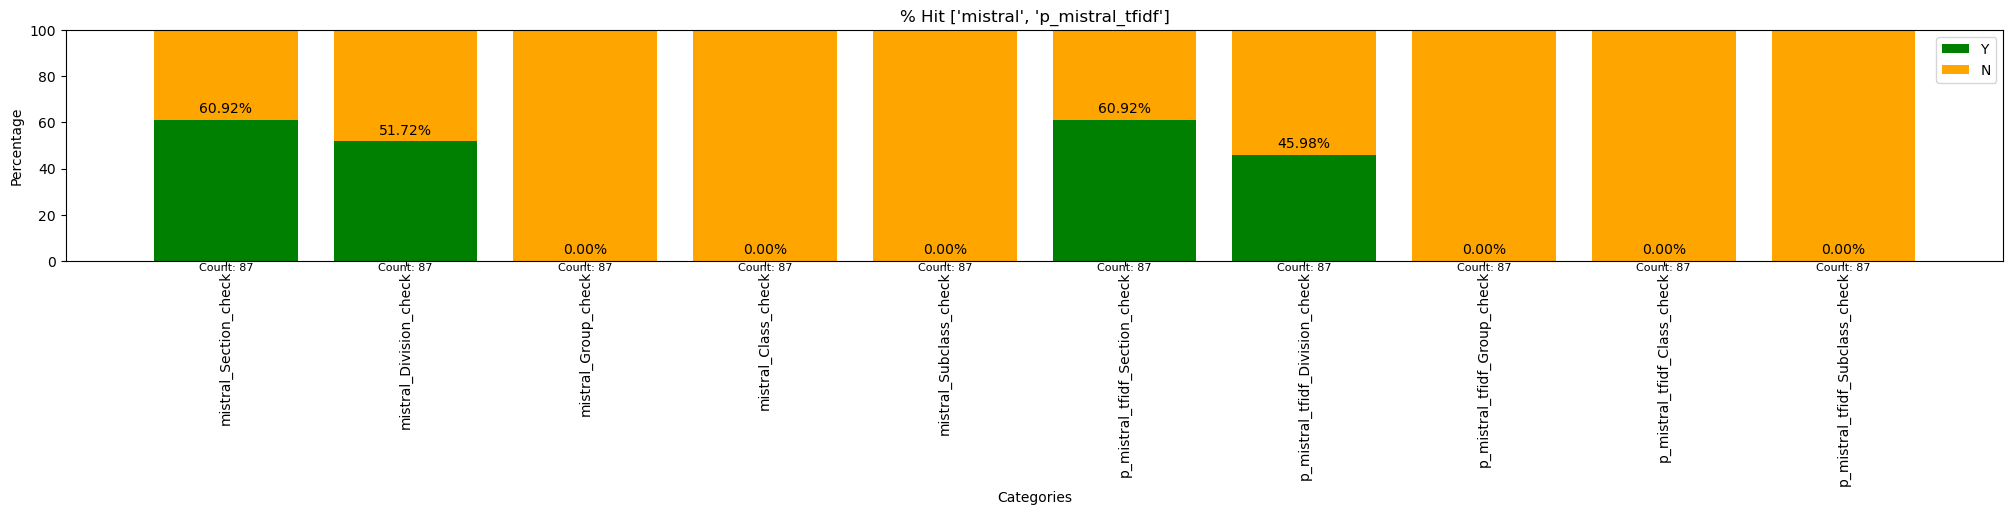

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

prefixes1 = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart']
prefixes2 = ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes3 = ['p_sd_azma_bart', 'p_azma_bart_tfidf']
prefixes4 = ['p_sd_fb_bart', 'p_fb_bart_tfidf']
prefixes5 = ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']
prefixes6 = ['p_llama','p_llama_tfidf']
prefixes7 = ['gemma','p_gemma_tfidf']
prefixes8 = ['mistral','p_mistral_tfidf']

prefix_sets = [
    ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart','p_llama'],
    ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_llama_tfidf'],
    ['p_sd_azma_bart', 'p_azma_bart_tfidf'],
    ['p_sd_fb_bart', 'p_fb_bart_tfidf'],
    ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf'],
    ['p_llama','p_llama_tfidf'],
    ['gemma','p_gemma_tfidf'],
    ['mistral','p_mistral_tfidf']
]


for prefix_set in prefix_sets:
    # Create groups based on the current prefix set
    groups = {prefix: [] for prefix in prefix_set}

    for col in vdf.columns:
        if col.endswith('_check'):
            for prefix in prefix_set:
                if col.startswith(prefix):
                    groups[prefix].append(col)
                    break

    # Filter out empty groups
    groups = {k: v for k, v in groups.items() if v}

    # Calculate the percentage of 'Y' and 'N' for each column
    check_columns = [col for sublist in groups.values() for col in sublist]
    if not check_columns:
        print(f"No columns found for prefix set: {prefix_set}")
        continue
    
    # Calculate percentages and base counts
    percentages_df = vdf[check_columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0).transpose()
    base_counts = vdf[check_columns].notnull().sum()  # Base count of non-null records

    if percentages_df.empty:
        print(f"No data available for prefix set: {prefix_set}")
        continue

    # Plotting
    fig, ax = plt.subplots(figsize=(25, 3))

    # Check if 'Y' and 'N' columns exist in percentages_df
    if 'Y' in percentages_df.columns and 'N' in percentages_df.columns:
        bars1 = ax.bar(percentages_df.index, percentages_df['Y'], color='green', label='Y')
        bars2 = ax.bar(percentages_df.index, percentages_df['N'], bottom=percentages_df['Y'], color='orange', label='N')

        # Adding data labels for percentages
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Adding base count labels
        for i, col in enumerate(percentages_df.index):
            base_count = base_counts.loc[col]
            ax.text(i, -5, f'Count: {base_count}', ha='center', va='bottom', fontsize=8, color='black')

        # Customizing the plot
        ax.set_title(f'% Hit {prefix_set}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)
        ax.legend()

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Show plot
        plt.show()
    else:
        print(f"'Y' and/or 'N' columns not found for prefix set: {prefix_set}")

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

prefixes1 = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart']
prefixes2 = ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes3 = ['p_sd_azma_bart', 'p_azma_bart_tfidf']
prefixes4 = ['p_sd_fb_bart', 'p_fb_bart_tfidf']
prefixes5 = ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']
prefixes6 = ['p_llama','p_llama_tfidf']
prefixes7 = ['gemma','p_gemma_tfidf']
prefixes8 = ['mistral','p_mistral_tfidf']

prefix_sets = [
    ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart','p_llama'],
    ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_llama_tfidf'],
    ['p_sd_azma_bart', 'p_azma_bart_tfidf'],
    ['p_sd_fb_bart', 'p_fb_bart_tfidf'],
    ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf'],
    ['p_llama','p_llama_tfidf'],
    ['gemma','p_gemma_tfidf'],
    ['mistral','p_mistral_tfidf']
]

results = []

for prefix_set in prefix_sets:
    # Create groups based on the current prefix set
    groups = {prefix: [] for prefix in prefix_set}

    for col in vdf.columns:
        if col.endswith('_check'):
            for prefix in prefix_set:
                if col.startswith(prefix):
                    groups[prefix].append(col)
                    break

    # Filter out empty groups
    groups = {k: v for k, v in groups.items() if v}

    # Calculate the percentage of 'Y' and 'N' for each column
    check_columns = [col for sublist in groups.values() for col in sublist]
    if not check_columns:
        print(f"No columns found for prefix set: {prefix_set}")
        continue
    
    # Calculate percentages and base counts
    percentages_df = vdf[check_columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0).transpose()
    base_counts = vdf[check_columns].notnull().sum()  # Base count of non-null records

    if percentages_df.empty:
        print(f"No data available for prefix set: {prefix_set}")
        continue

    # Collect results into a list of dictionaries
    for col in percentages_df.index:
        result = {
            'Prefix Set': ', '.join(prefix_set),
            'Column': col,
            'Y_Percentage': percentages_df.at[col, 'Y'] if 'Y' in percentages_df.columns else 0,
            'N_Percentage': percentages_df.at[col, 'N'] if 'N' in percentages_df.columns else 0,
            'Base_Count': base_counts.loc[col]
        }
        results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)
results_df.to_excel('results_df_division.xlsx', index=False)

                                            Prefix Set  \
0    p_sd_azma_bart, p_sd_fb_bart, p_sd_philschmid_...   
1    p_sd_azma_bart, p_sd_fb_bart, p_sd_philschmid_...   
2    p_sd_azma_bart, p_sd_fb_bart, p_sd_philschmid_...   
3    p_sd_azma_bart, p_sd_fb_bart, p_sd_philschmid_...   
4    p_sd_azma_bart, p_sd_fb_bart, p_sd_philschmid_...   
..                                                 ...   
100                           mistral, p_mistral_tfidf   
101                           mistral, p_mistral_tfidf   
102                           mistral, p_mistral_tfidf   
103                           mistral, p_mistral_tfidf   
104                           mistral, p_mistral_tfidf   

                             Column  Y_Percentage  N_Percentage  Base_Count  
0      p_sd_azma_bart_Section_check     64.367816     35.632184          87  
1     p_sd_azma_bart_Division_check     50.574713     49.425287          87  
2        p_sd_azma_bart_Group_check      0.000000    100.000000      

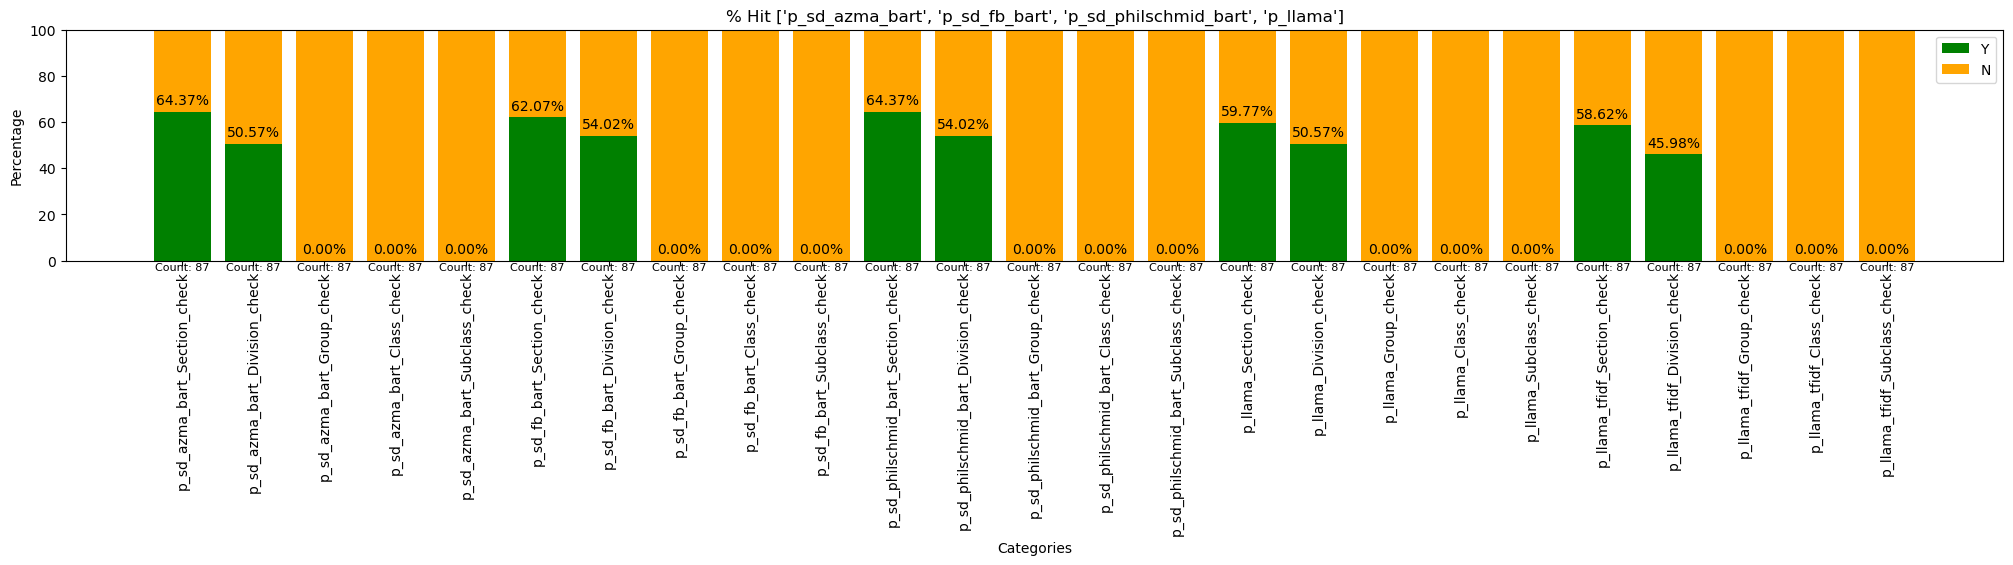

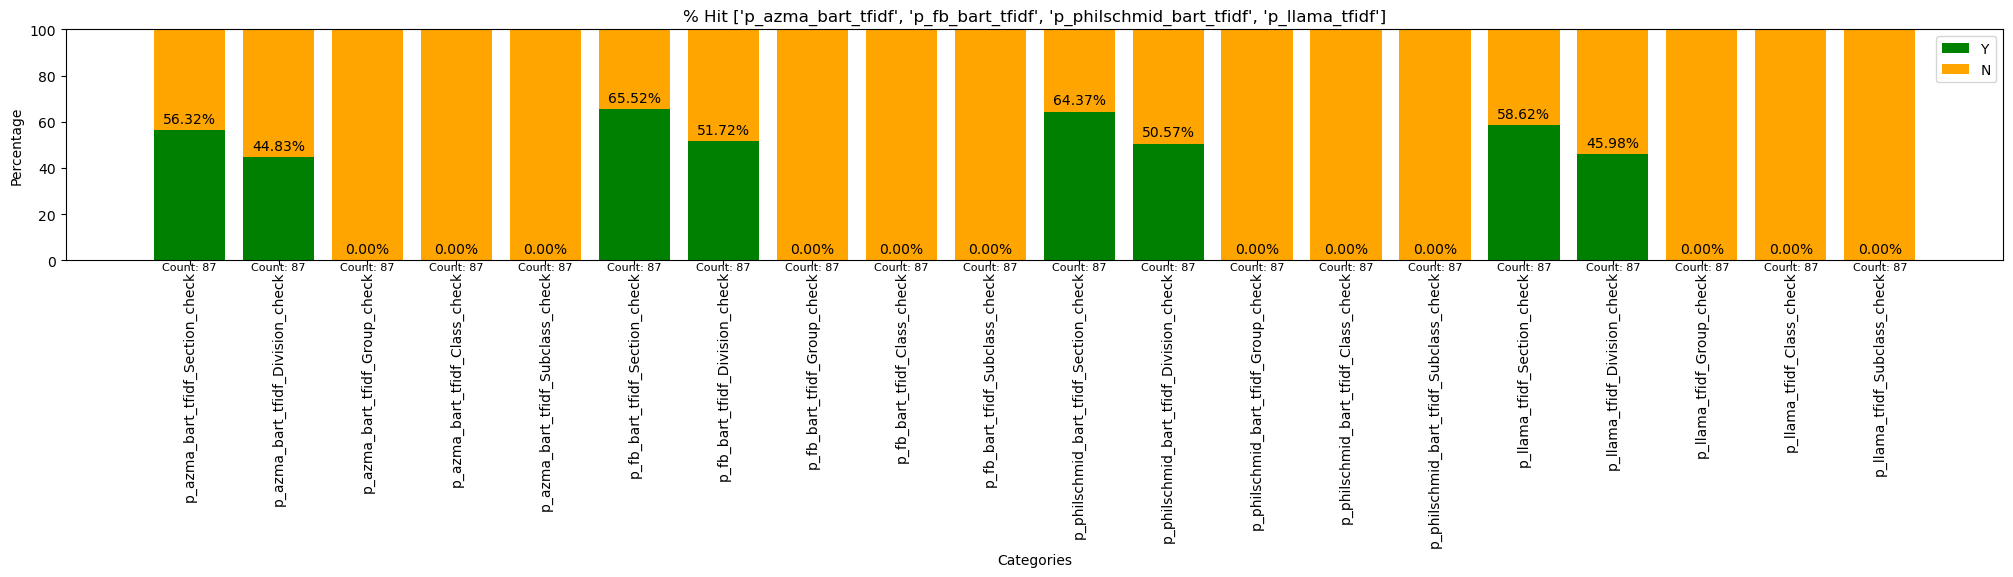

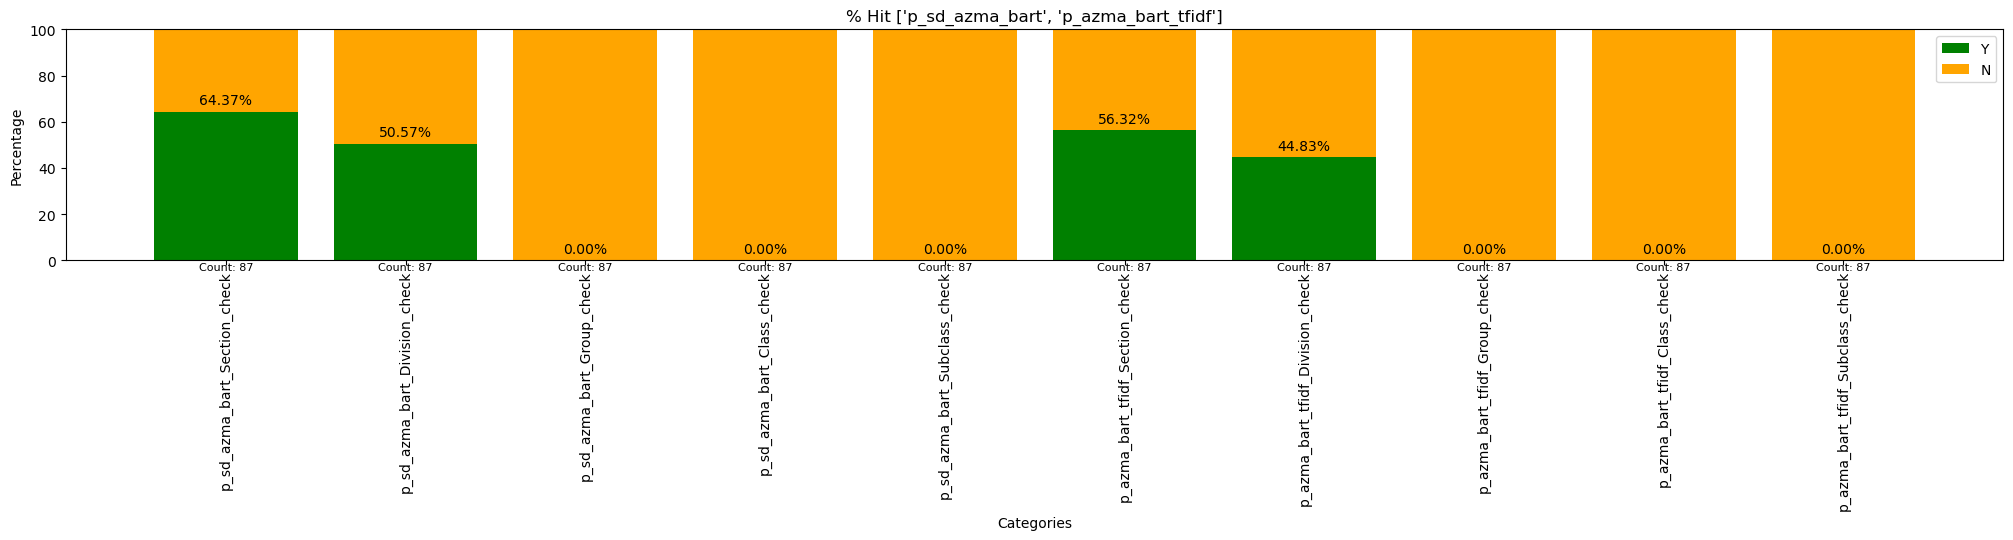

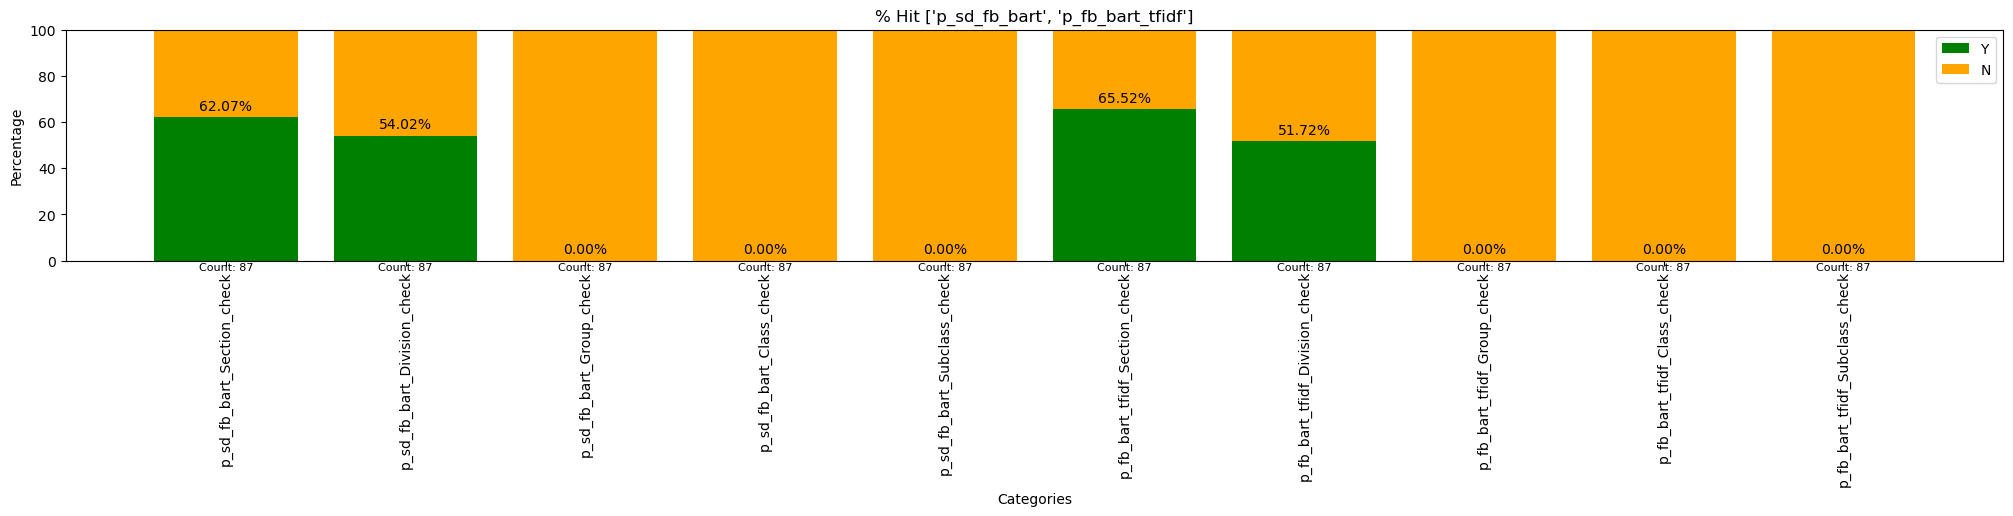

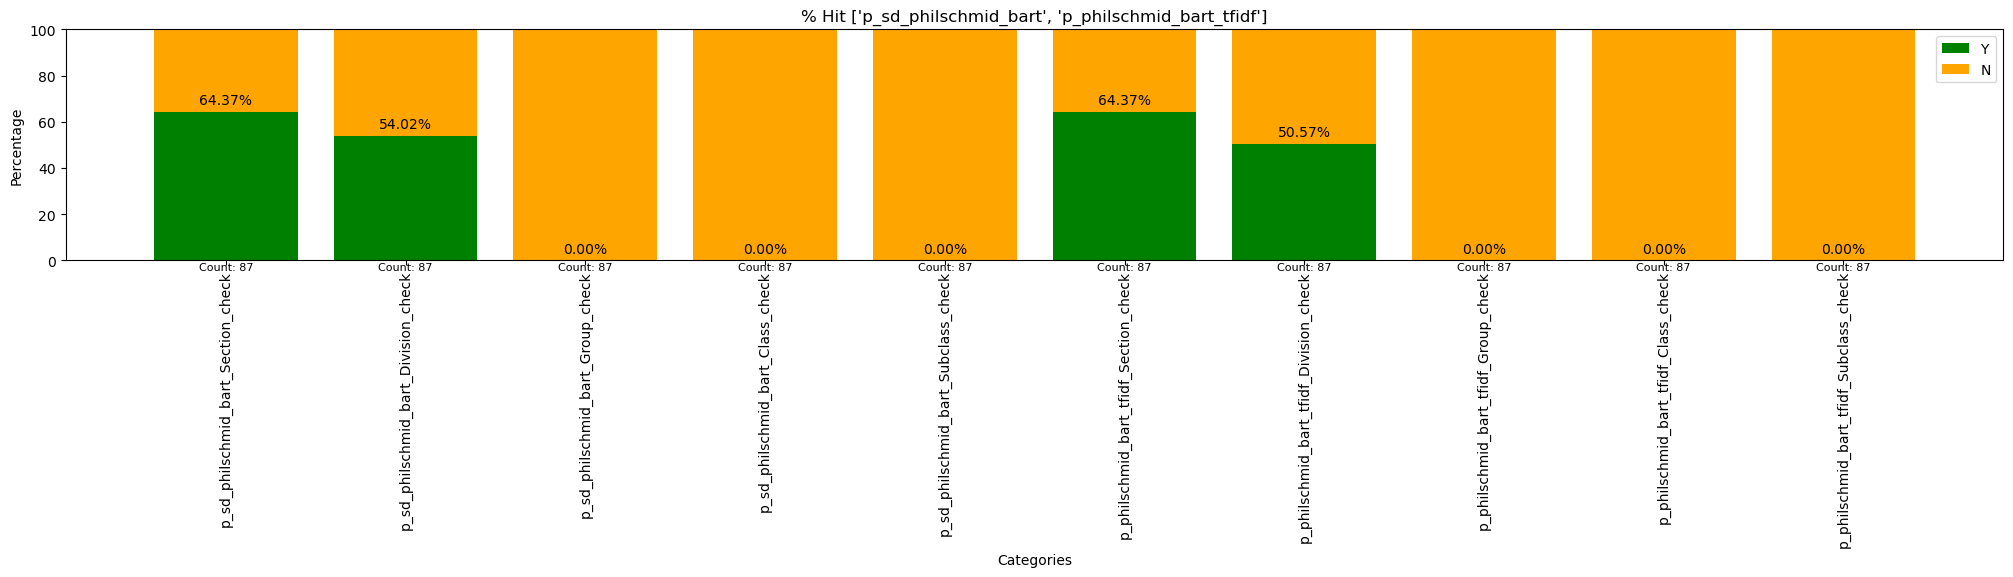

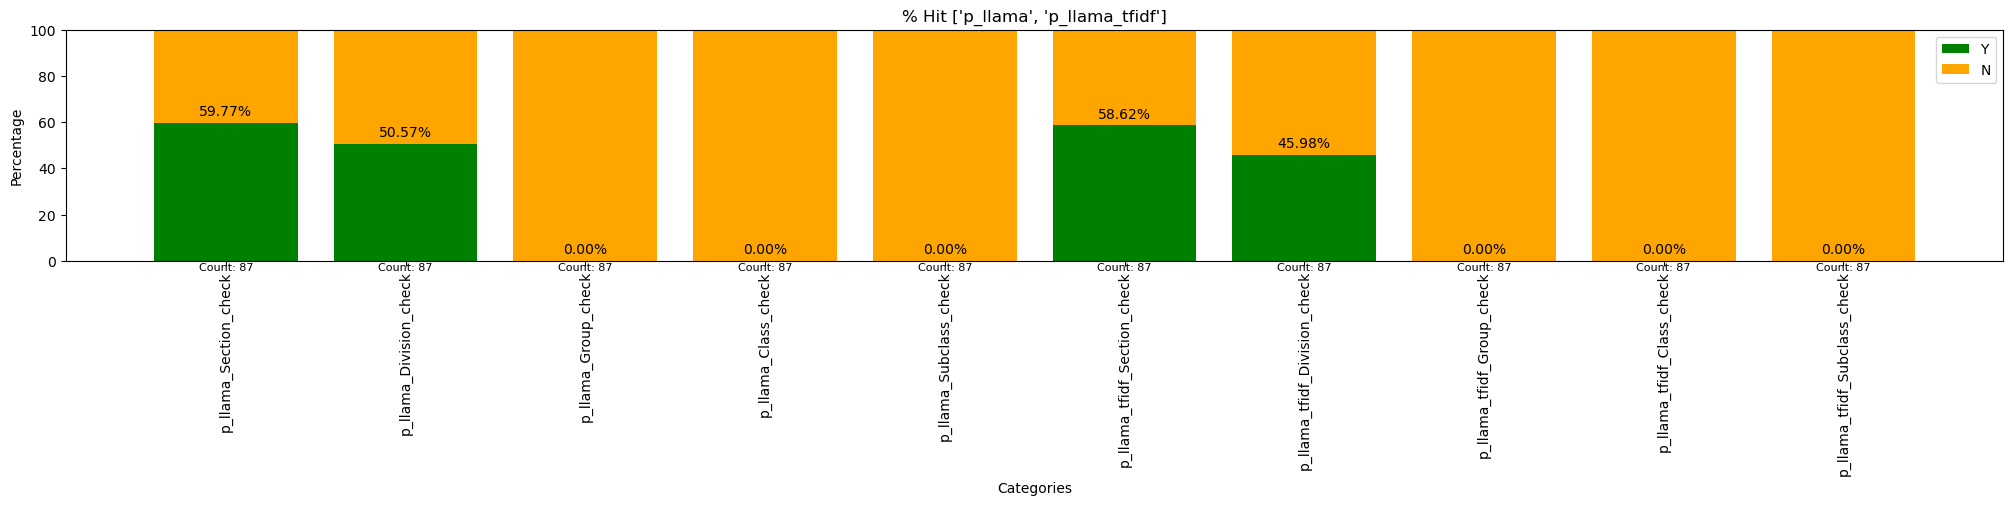

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

prefixes1 = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart']
prefixes2 = ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes3 = ['p_sd_azma_bart', 'p_azma_bart_tfidf']
prefixes4 = ['p_sd_fb_bart', 'p_fb_bart_tfidf']
prefixes5 = ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']
prefixes6 = ['p_llama','p_llama_tfidf']

prefix_sets = [
    ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart','p_llama'],
    ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_llama_tfidf'],
    ['p_sd_azma_bart', 'p_azma_bart_tfidf'],
    ['p_sd_fb_bart', 'p_fb_bart_tfidf'],
    ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf'],
    ['p_llama','p_llama_tfidf']
]

for prefix_set in prefix_sets:
    # Create groups based on the current prefix set
    groups = {prefix: [] for prefix in prefix_set}

    for col in vdf.columns:
        if col.endswith('_check'):
            for prefix in prefix_set:
                if col.startswith(prefix):
                    groups[prefix].append(col)
                    break

    # Filter out empty groups
    groups = {k: v for k, v in groups.items() if v}

    # Calculate the percentage of 'Y' and 'N' for each column
    check_columns = [col for sublist in groups.values() for col in sublist]
    if not check_columns:
        print(f"No columns found for prefix set: {prefix_set}")
        continue
    
    # Calculate percentages and base counts
    percentages_df = vdf[check_columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0).transpose()
    base_counts = vdf[check_columns].notnull().sum()  # Base count of non-null records

    if percentages_df.empty:
        print(f"No data available for prefix set: {prefix_set}")
        continue

    # Plotting
    fig, ax = plt.subplots(figsize=(25, 3))

    # Check if 'Y' and 'N' columns exist in percentages_df
    if 'Y' in percentages_df.columns and 'N' in percentages_df.columns:
        bars1 = ax.bar(percentages_df.index, percentages_df['Y'], color='green', label='Y')
        bars2 = ax.bar(percentages_df.index, percentages_df['N'], bottom=percentages_df['Y'], color='orange', label='N')

        # Adding data labels for percentages
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Adding base count labels
        for i, col in enumerate(percentages_df.index):
            base_count = base_counts.loc[col]
            ax.text(i, -5, f'Count: {base_count}', ha='center', va='bottom', fontsize=8, color='black')

        # Customizing the plot
        ax.set_title(f'% Hit {prefix_set}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)
        ax.legend()

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Show plot
        plt.show()
    else:
        print(f"'Y' and/or 'N' columns not found for prefix set: {prefix_set}")

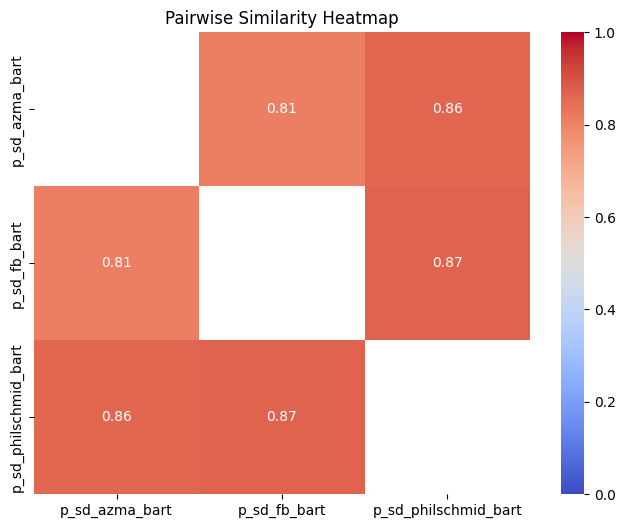

In [98]:
vdf_analysis = vdf

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert lists to sets
vdf_analysis['set_p_sd_azma_bart'] = vdf_analysis['p_sd_azma_bart'].apply(set)
vdf_analysis['set_p_sd_fb_bart'] = vdf_analysis['p_sd_fb_bart'].apply(set)
vdf_analysis['set_p_sd_philschmid_bart'] = vdf_analysis['p_sd_philschmid_bart'].apply(set)

# Compute Jaccard similarity between each pair of sets
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

# Calculate average pairwise similarities
def calculate_average_similarity(df):
    similarity_matrix = pd.DataFrame(index=['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'],
                                     columns=['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'])
    
    similarities = {
        ('p_sd_azma_bart', 'p_sd_fb_bart'): [],
        ('p_sd_fb_bart', 'p_sd_philschmid_bart'): [],
        ('p_sd_azma_bart', 'p_sd_philschmid_bart'): []
    }
    
    for index, row in df.iterrows():
        set1 = row['set_p_sd_azma_bart']
        set2 = row['set_p_sd_fb_bart']
        set3 = row['set_p_sd_philschmid_bart']
        
        similarities[('p_sd_azma_bart', 'p_sd_fb_bart')].append(jaccard_similarity(set1, set2))
        similarities[('p_sd_fb_bart', 'p_sd_philschmid_bart')].append(jaccard_similarity(set2, set3))
        similarities[('p_sd_azma_bart', 'p_sd_philschmid_bart')].append(jaccard_similarity(set1, set3))
    
    # Average similarities
    similarity_matrix.at['p_sd_azma_bart', 'p_sd_fb_bart'] = sum(similarities[('p_sd_azma_bart', 'p_sd_fb_bart')]) / len(similarities[('p_sd_azma_bart', 'p_sd_fb_bart')])
    similarity_matrix.at['p_sd_fb_bart', 'p_sd_azma_bart'] = similarity_matrix.at['p_sd_azma_bart', 'p_sd_fb_bart']
    similarity_matrix.at['p_sd_fb_bart', 'p_sd_philschmid_bart'] = sum(similarities[('p_sd_fb_bart', 'p_sd_philschmid_bart')]) / len(similarities[('p_sd_fb_bart', 'p_sd_philschmid_bart')])
    similarity_matrix.at['p_sd_philschmid_bart', 'p_sd_fb_bart'] = similarity_matrix.at['p_sd_fb_bart', 'p_sd_philschmid_bart']
    similarity_matrix.at['p_sd_azma_bart', 'p_sd_philschmid_bart'] = sum(similarities[('p_sd_azma_bart', 'p_sd_philschmid_bart')]) / len(similarities[('p_sd_azma_bart', 'p_sd_philschmid_bart')])
    similarity_matrix.at['p_sd_philschmid_bart', 'p_sd_azma_bart'] = similarity_matrix.at['p_sd_azma_bart', 'p_sd_philschmid_bart']
    
    # Ensure the DataFrame is of numeric type
    similarity_matrix = similarity_matrix.apply(pd.to_numeric, errors='coerce')

    return similarity_matrix

# Apply the similarity calculation
average_similarity_df = calculate_average_similarity(vdf)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(average_similarity_df, annot=True, cmap='coolwarm', vmin=0, vmax=1, fmt='.2f')
plt.title('Pairwise Similarity Heatmap')
plt.show()

In [11]:
# Custom input text
input_text = "group relating design manufacture distribution paper personal business organising tools well general"

# mapping
level_map = {
    'Section': ('Section', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_1.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_section_classifier", ssic_1),
    'Division': ('Division', ssic_df.iloc[:, [0, 1, 6, 10, 11, 12, 13]].drop_duplicates(), ssic_2.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_division_classifier", ssic_2),
    'Group': ('Group', ssic_df.iloc[:, [0, 1, 7, 10, 11, 12, 13]].drop_duplicates(), ssic_3.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_group_classifier", ssic_3),
    'Class': ('Class', ssic_df.iloc[:, [0, 1, 8, 10, 11, 12, 13]].drop_duplicates(), ssic_4.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_class_classifier", ssic_4),
    'Subclass': ('SSIC 2020', ssic_df.iloc[:, [0, 1, 9, 10, 11, 12, 13]].drop_duplicates(), ssic_5.iloc[:, [0, 1]].drop_duplicates().reset_index(drop=True), "nusebacra/ssicsync_subclass_classifier", ssic_5)
}

# Get the values for a and b based on the lvl_train
lvl_train, df_streamlit, ssic_n_sl, model, ssic_lvl = level_map.get(level, ('default_a', 'default_b', 'default_c', 'default_d', 'default_e', 'default_f'))
lvl_train_title = lvl_train + " Title"

# Define the function to predict scores and categories
def predict_text(text, tokenizer, model):
    if not isinstance(text, str) or not text.strip():
        return []

    predict_input = tokenizer.encode(text, truncation=True, padding=True, return_tensors="tf")
    output = model(predict_input)[0]
    output_array = output.numpy()[0]
    probs = tf.nn.softmax(output_array)
    top_10_indices = tf.argsort(probs, direction='DESCENDING')[:3].numpy()
    return tuple(int(idx) for idx in top_10_indices)

# Function to apply model to input text and get predictions for all levels
def apply_model_to_text(input_text):
    results = {}
    for level, (lvl_train, df_streamlit, ssic_n_sl, model_name, ssic_lvl) in level_map.items():
        lvl_train_title = lvl_train + " Title"

        df_prep = ssic_df[[lvl_train, 'Detailed Definitions']]
        df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
        df_prep = df_prep[[lvl_train, 'encoded_cat']].drop_duplicates()

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

        predictions = predict_text(input_text, tokenizer, model)
        merged_df = df_prep.merge(ssic_lvl[[lvl_train, lvl_train_title]], on=lvl_train, how='left')
        mapping_dict = dict(zip(merged_df['encoded_cat'], merged_df[[lvl_train, lvl_train_title]].apply(tuple, axis=1)))
        mapped_values = [mapping_dict.get(pred, ('Unknown', 'Unknown')) for pred in predictions]

        # Remove duplicates from the mapped values while maintaining order
        seen = set()
        unique_mapped_values = []
        for item in mapped_values:
            if item[0] not in seen:
                unique_mapped_values.append(item)
                seen.add(item[0])

        results[level] = unique_mapped_values
    
    return results

# Get the results for the custom input text
results = apply_model_to_text(input_text)
results

C:\Users\royle\AppData\Local\Temp\ipykernel_22792\2348857517.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prep['encoded_cat'] = df_prep[lvl_train].astype('category').cat.codes
Some layers from the model checkpoint at nusebacra/ssicsync_section_classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly id

{'Section': [('M', 'PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'), ('C', 'MANUFACTURING'), ('S', 'OTHER SERVICE ACTIVITIES')], 'Division': [('74', 'OTHER PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES'), ('71', 'ARCHITECTURAL AND ENGINEERING ACTIVITIES; TECHNICAL TESTING AND ANALYSIS'), ('62', 'COMPUTER PROGRAMMING, INFORMATION TECHNOLOGY CONSULTANCY AND RELATED ACTIVITIES')], 'Group': [('741', 'SPECIALISED DESIGN ACTIVITIES'), ('181', 'PRINTING AND SERVICE ACTIVITIES RELATED TO PRINTING'), ('329', 'OTHER MANUFACTURING N.E.C.')], 'Class': [('6201', 'Computer Programming Activities'), ('7112', 'Engineering Design and Consultancy Activities'), ('3290', 'Other Manufacturing n.e.c.')], 'Subclass': [('71122', 'Process and industrial plant engineering design and consultancy services'), ('58120', 'Publishing of directories and mailing lists (including financial databases)'), ('62011', 'Development of software and applications (except games and cybersecurity)')]}


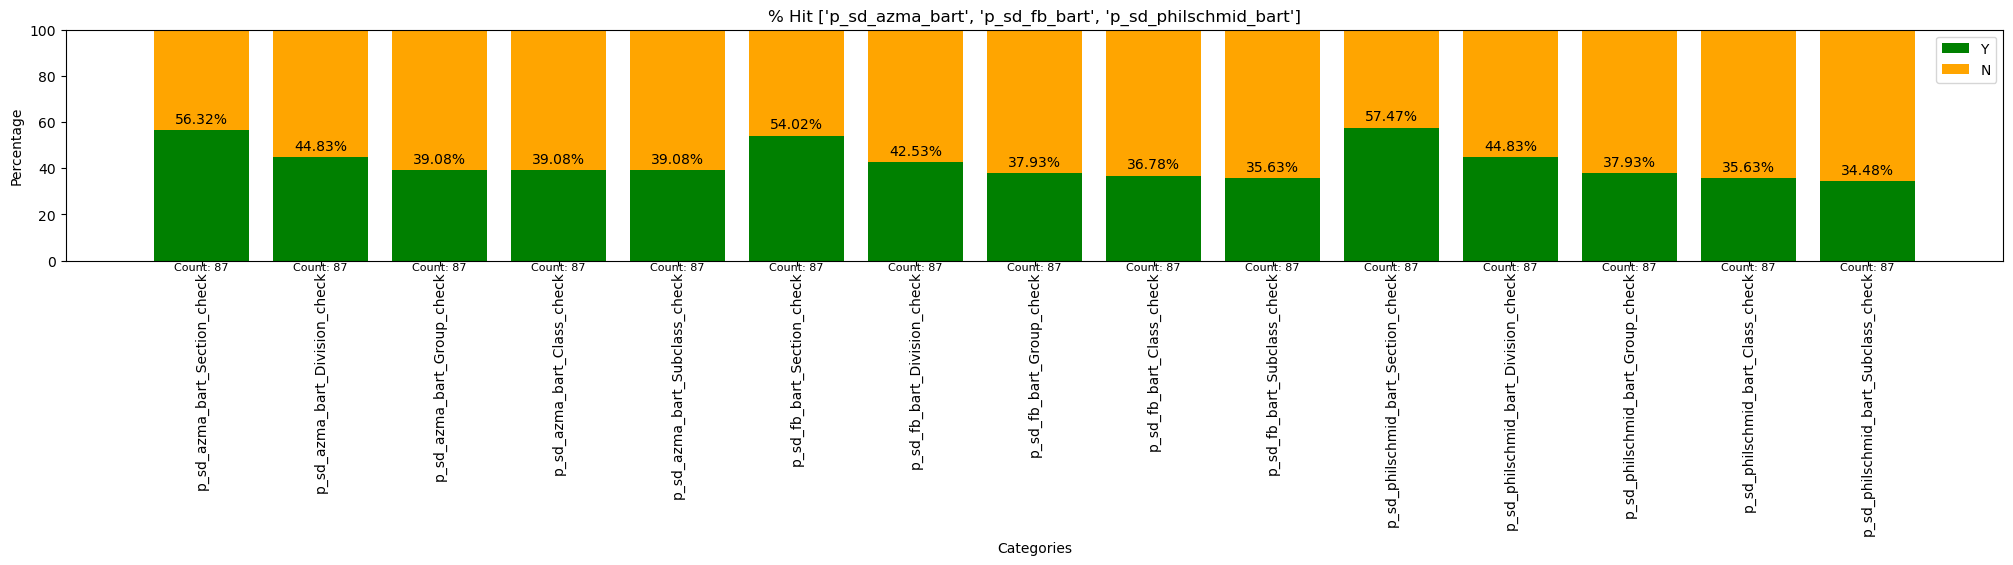

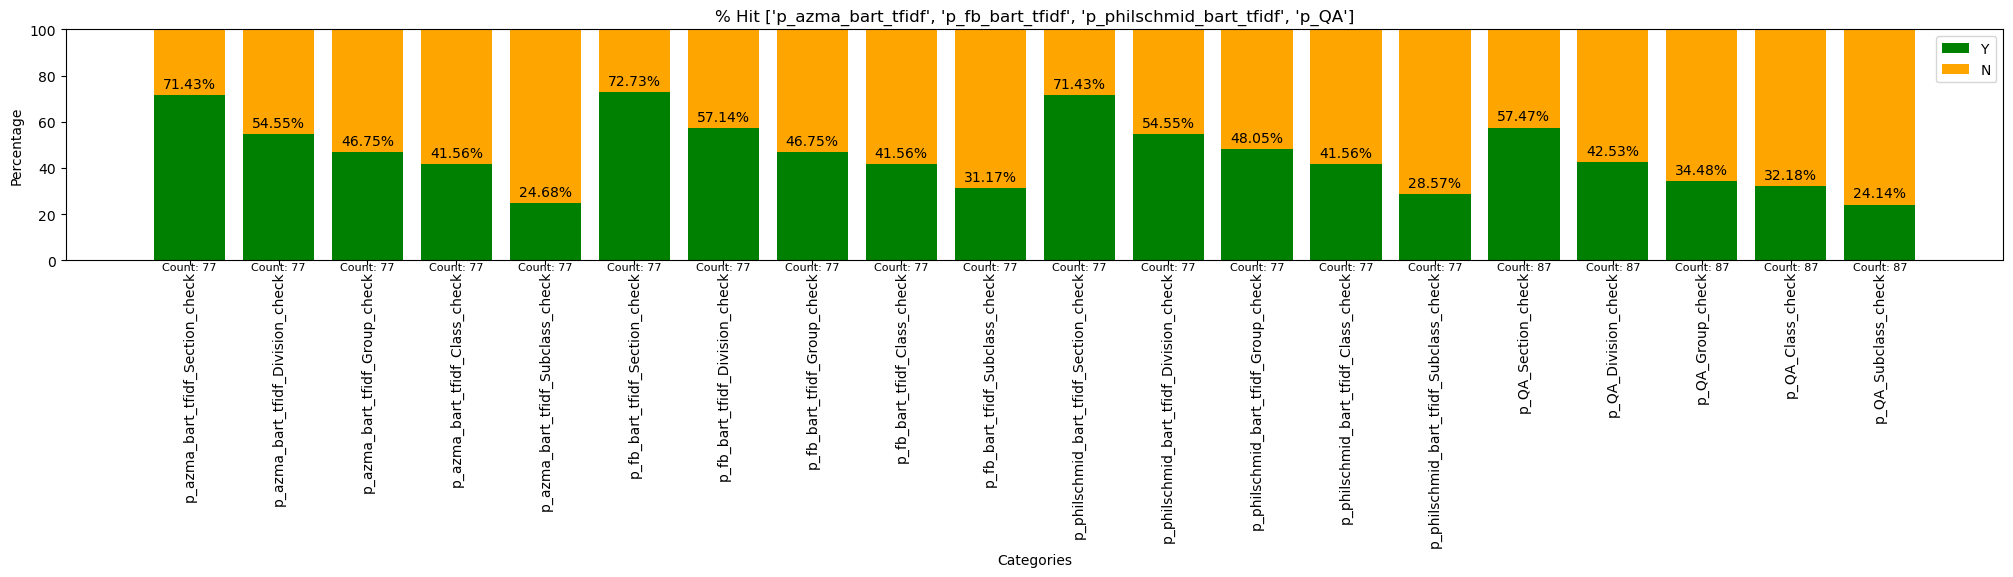

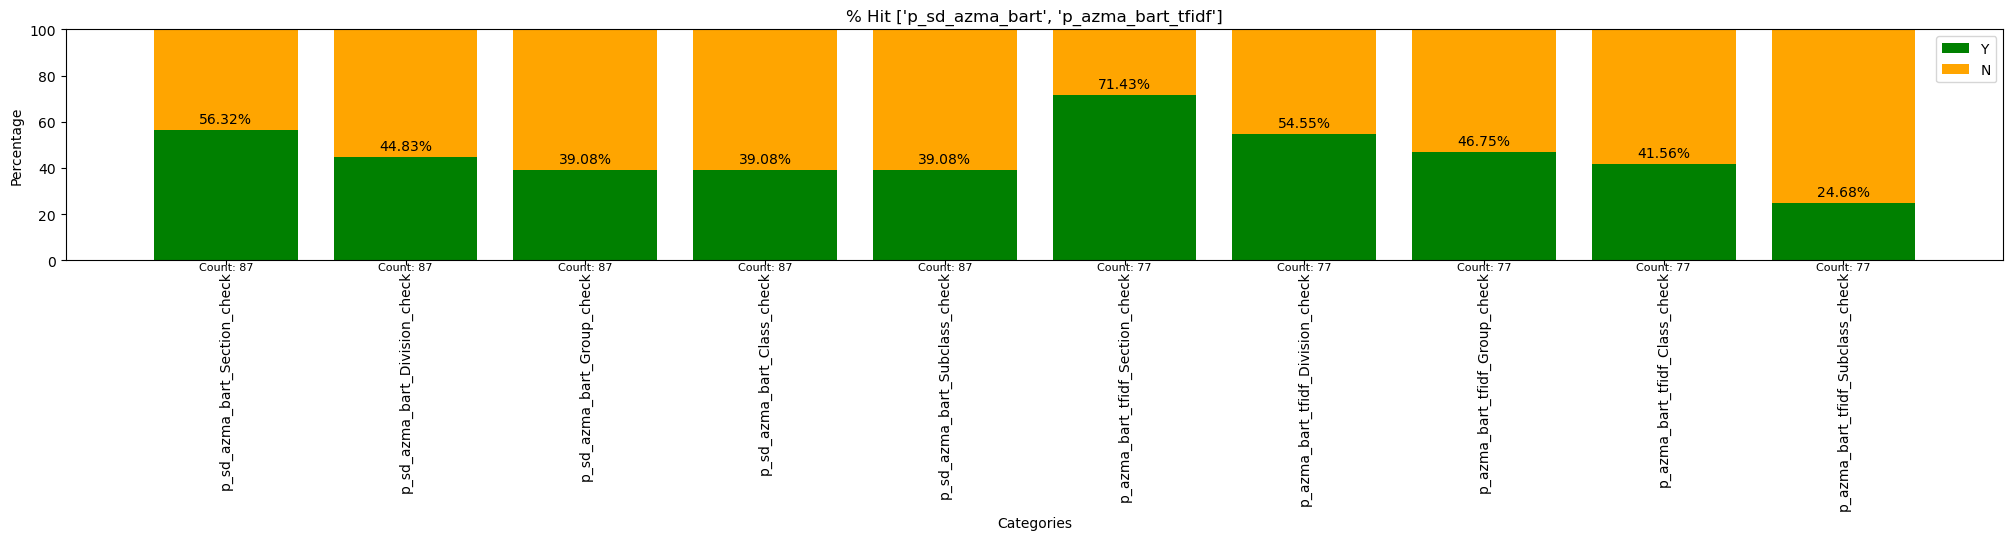

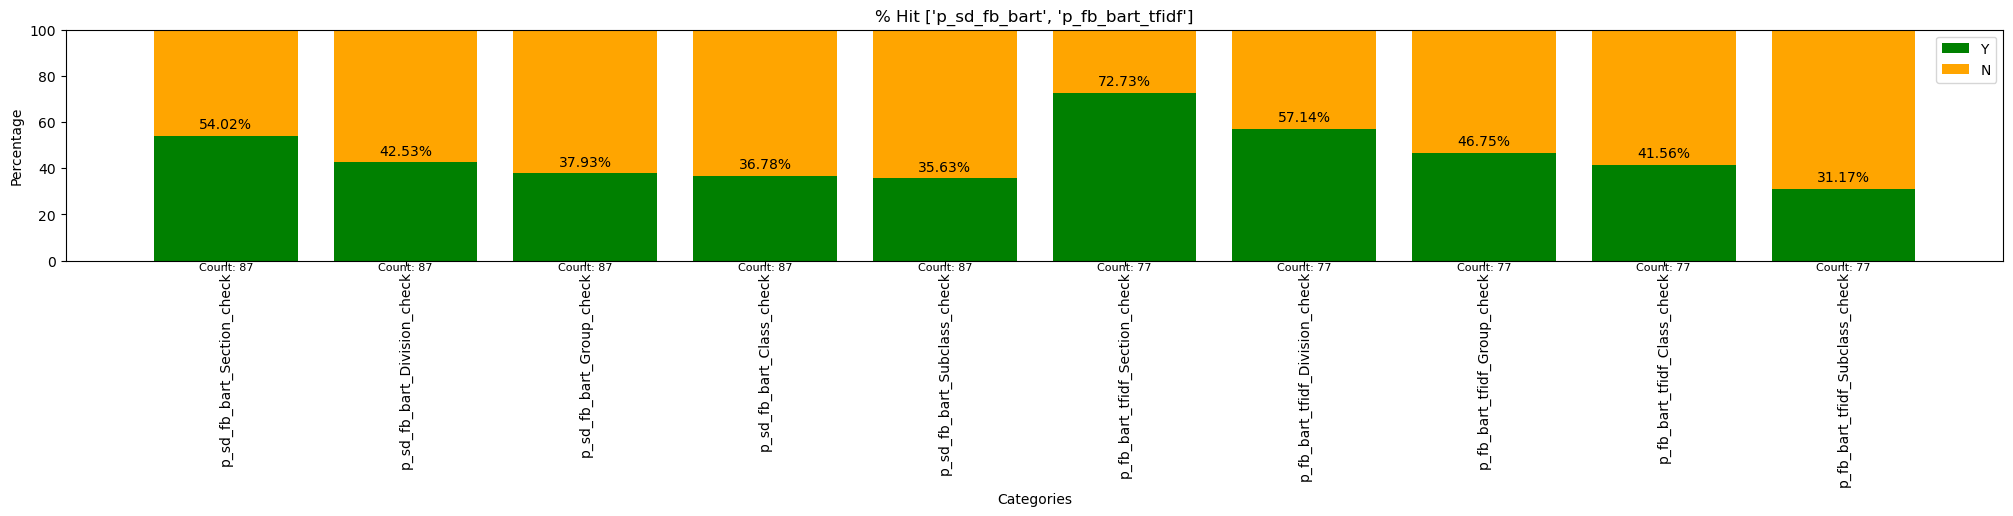

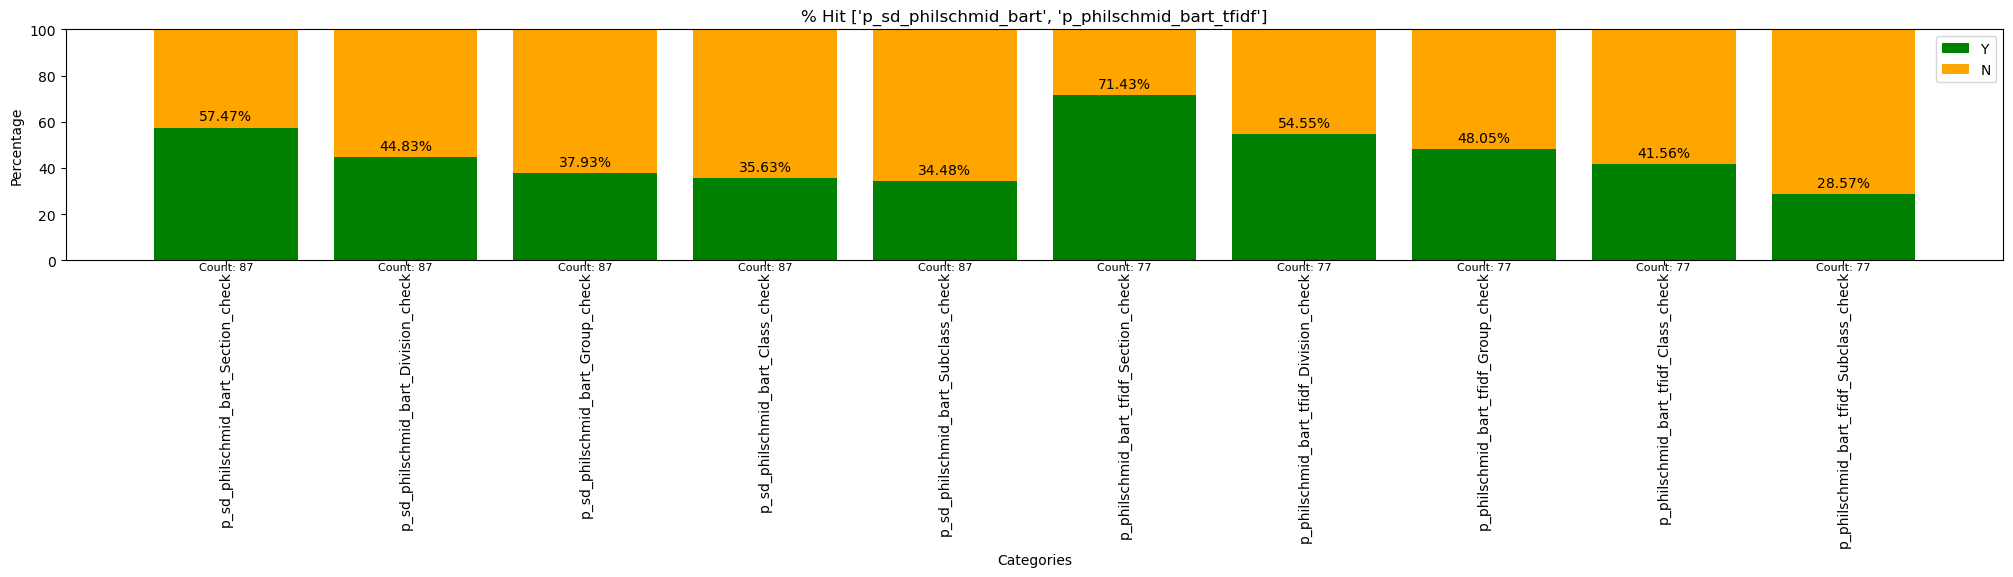

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

prefixes1 = ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart']
prefixes2 = ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA']
prefixes3 = ['p_sd_azma_bart', 'p_azma_bart_tfidf']
prefixes4 = ['p_sd_fb_bart', 'p_fb_bart_tfidf']
prefixes5 = ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']

prefix_sets = [
    ['p_sd_azma_bart', 'p_sd_fb_bart', 'p_sd_philschmid_bart'],
    ['p_azma_bart_tfidf', 'p_fb_bart_tfidf', 'p_philschmid_bart_tfidf', 'p_QA'],
    ['p_sd_azma_bart', 'p_azma_bart_tfidf'],
    ['p_sd_fb_bart', 'p_fb_bart_tfidf'],
    ['p_sd_philschmid_bart', 'p_philschmid_bart_tfidf']
]

for prefix_set in prefix_sets:
    # Create groups based on the current prefix set
    groups = {prefix: [] for prefix in prefix_set}

    for col in vdf.columns:
        if col.endswith('_check'):
            for prefix in prefix_set:
                if col.startswith(prefix):
                    groups[prefix].append(col)
                    break

    # Filter out empty groups
    groups = {k: v for k, v in groups.items() if v}

    # Calculate the percentage of 'Y' and 'N' for each column
    check_columns = [col for sublist in groups.values() for col in sublist]
    if not check_columns:
        print(f"No columns found for prefix set: {prefix_set}")
        continue
    
    # Calculate percentages and base counts
    percentages_df = vdf[check_columns].apply(lambda x: x.value_counts(normalize=True) * 100).fillna(0).transpose()
    base_counts = vdf[check_columns].notnull().sum()  # Base count of non-null records

    if percentages_df.empty:
        print(f"No data available for prefix set: {prefix_set}")
        continue

    # Plotting
    fig, ax = plt.subplots(figsize=(25, 3))

    # Check if 'Y' and 'N' columns exist in percentages_df
    if 'Y' in percentages_df.columns and 'N' in percentages_df.columns:
        bars1 = ax.bar(percentages_df.index, percentages_df['Y'], color='green', label='Y')
        bars2 = ax.bar(percentages_df.index, percentages_df['N'], bottom=percentages_df['Y'], color='orange', label='N')

        # Adding data labels for percentages
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

        # Adding base count labels
        for i, col in enumerate(percentages_df.index):
            base_count = base_counts.loc[col]
            ax.text(i, -5, f'Count: {base_count}', ha='center', va='bottom', fontsize=8, color='black')

        # Customizing the plot
        ax.set_title(f'% Hit {prefix_set}')
        ax.set_xlabel('Categories')
        ax.set_ylabel('Percentage')
        ax.set_ylim(0, 100)
        ax.legend()

        # Rotate x-axis labels for better visibility if needed
        plt.xticks(rotation=90)

        # Show plot
        plt.show()
    else:
        print(f"'Y' and/or 'N' columns not found for prefix set: {prefix_set}")